In [1]:
!pip install torch
!pip install torchdiffeq
!pip install matplotlib
!pip install torchvision
!pip install  scikit-learn

# MNIST

In [161]:
from torchvision import datasets as dts
from torchvision.transforms import ToTensor 
traindt = dts.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
testdt = dts.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [162]:
traindt.training_file

'training.pt'

In [163]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
# from torchdiffeq import odeint_adjoint as odeint
from torchdiffeq import odeint
import matplotlib.pyplot as plt
import numpy as np
import time
import psutil
from sklearn.manifold import TSNE

# Конфигурация
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128
epochs = 10

# 1. Загрузка и фильтрация данных (только классы 0 и 8)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

full_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
full_test = datasets.MNIST('./data', train=False, transform=transform)

# Фильтрация классов 0 и 8
class_mask_train = torch.where((full_train.targets == 0) | (full_train.targets == 8))[0]
class_mask_test = torch.where((full_test.targets == 0) | (full_test.targets == 8))[0]

train_data = Subset(full_train, class_mask_train)
test_data = Subset(full_test, class_mask_test)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)



In [183]:
train_data

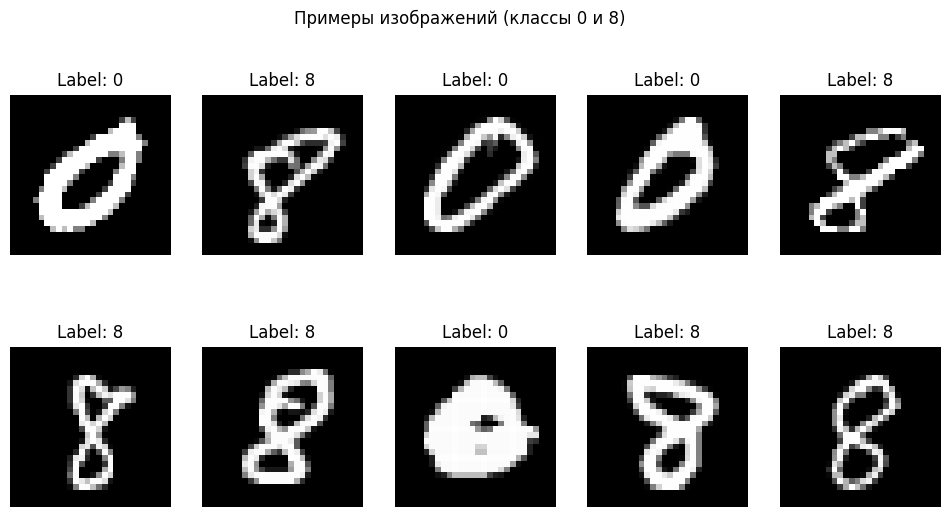

In [164]:
# 2. Визуализация данных
images, labels = next(iter(train_loader))
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title(f'Label: {labels[i].item()}')
    plt.axis('off')
plt.suptitle('Примеры изображений (классы 0 и 8)')
plt.show()


In [276]:

# 3. Архитектуры моделей
class ResNetBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_channels, 64),
            nn.Tanh(),
            nn.Linear(64, in_channels)
        )
        
    def forward(self, x):
        return x + self.net(x)
        
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 784//2),
            nn.Tanh(),
            nn.Linear(784//4, 784//8),
            nn.Tanh(),
            nn.Linear(784//16, 784//32),
            nn.Tanh(),
            nn.Linear(784//64, 64)
        )
        self.classifier = nn.Linear(64, 1)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.net(x)
        return self.classifier(x)
        
class ResNet(nn.Module):
    def __init__(self, size=16):
        super().__init__()
        self.encoder = nn.Linear(784, 64)
        self.blocks = nn.Sequential(*[ResNetBlock(64) for _ in range(size)])
        self.classifier = nn.Linear(64, 1)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.encoder(x)
        for block in self.blocks:
            x = block(x)
        return self.classifier(x)

class ODEFunc(nn.Module):
    def __init__(self):
        super().__init__()
        self.odefunc = nn.Sequential(
            nn.Linear(64, 64),
            nn.GELU(),
            nn.Linear(64, 64), 
        )
    def forward(self, t, x):
        return self.odefunc(x)
        
class ODEBlock(nn.Module):
    def __init__(self, odefunc, m):
        super().__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor(np.linspace(0, 1, m)).float()
        
    def forward(self, x0):
        self.integration_time = self.integration_time.to(x0)
        return odeint(self.odefunc, x0, self.integration_time, method='dopri5', rtol=1e-1, atol=1e-2)[-1]

class NeuralODE(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.encoder = nn.Linear(784, 64)
        
        self.odeblock = ODEBlock(ODEFunc(), m)
        self.classifier = nn.Linear(64, 1)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.encoder(x)
        x = self.odeblock(x)
        return self.classifier(x)


In [277]:
help(odeint)

Help on function odeint in module torchdiffeq._impl.odeint:

odeint(func, y0, t, *, rtol=1e-07, atol=1e-09, method=None, options=None, event_fn=None)
    Integrate a system of ordinary differential equations.

    Solves the initial value problem for a non-stiff system of first order ODEs:
        ```
        dy/dt = func(t, y), y(t[0]) = y0
        ```
    where y is a Tensor or tuple of Tensors of any shape.

    Output dtypes and numerical precision are based on the dtypes of the inputs `y0`.

    Args:
        func: Function that maps a scalar Tensor `t` and a Tensor holding the state `y`
            into a Tensor of state derivatives with respect to time. Optionally, `y`
            can also be a tuple of Tensors.
        y0: N-D Tensor giving starting value of `y` at time point `t[0]`. Optionally, `y0`
            can also be a tuple of Tensors.
        t: 1-D Tensor holding a sequence of time points for which to solve for
            `y`, in either increasing or decreasing order

In [278]:

# 4. Обучение моделей
def train_model(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = []
    correct = 0
    total = 0
    start_time = time.time()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        predicted = (torch.sigmoid(output) > 0.5).float()*8
        
        correct += (predicted == target).sum().item()
        total += target.size(0)
        
    return {
        'time': time.time() - start_time,
        'loss': np.mean(train_loss),
        'acc': 100 * correct / total,
        # 'memory': psutil.Process().memory_info().rss // (1024 ** 2) 
    }

results = {'ResNet': [], 'NeuralODE': []}
criterion = nn.MSELoss()

In [285]:
# Инициализация моделей
resnet = ResNet(50).to(device)
optimizer_resnet = optim.Adam(resnet.parameters(), lr=0.0001)
# Цикл обучения
for epoch in range(epochs):
    res_stats = train_model(resnet, train_loader, criterion, optimizer_resnet) 
    results['ResNet'].append(res_stats)
    
    print(f'Epoch {epoch+1}:')
    print(f'ResNet | Loss: {res_stats["loss"]:.4f}, Acc: {res_stats["acc"]:.2f}%')
    print('---')


Epoch 1:
ResNet | Loss: 2.5297, Acc: 71.32%
---
Epoch 2:
ResNet | Loss: 0.5437, Acc: 73.52%
---
Epoch 3:
ResNet | Loss: 0.3314, Acc: 73.68%
---
Epoch 4:
ResNet | Loss: 0.2378, Acc: 73.62%
---
Epoch 5:
ResNet | Loss: 0.2237, Acc: 74.37%
---
Epoch 6:
ResNet | Loss: 0.1449, Acc: 73.31%
---
Epoch 7:
ResNet | Loss: 0.1348, Acc: 74.15%
---
Epoch 8:
ResNet | Loss: 0.1148, Acc: 73.34%
---
Epoch 9:
ResNet | Loss: 0.1063, Acc: 73.73%
---
Epoch 10:
ResNet | Loss: 0.0805, Acc: 74.43%
---


In [286]:
neural_ode = NeuralODE(m=6).to(device)
optimizer_node = optim.Adam(neural_ode.parameters(), lr=0.001)
for epoch in range(epochs):
    ode_stats = train_model(neural_ode, train_loader, criterion, optimizer_node)

    results['NeuralODE'].append(ode_stats)
    
    print(f'Epoch {epoch+1}:')
    print(f'NeuralODE | Loss: {ode_stats["loss"]:.4f}, Acc: {ode_stats["acc"]:.2f}%')
    print('---')

Epoch 1:
NeuralODE | Loss: 2.9809, Acc: 68.52%
---
Epoch 2:
NeuralODE | Loss: 0.8221, Acc: 73.54%
---
Epoch 3:
NeuralODE | Loss: 0.4749, Acc: 73.82%
---
Epoch 4:
NeuralODE | Loss: 0.3435, Acc: 73.08%
---
Epoch 5:
NeuralODE | Loss: 0.2920, Acc: 73.76%
---
Epoch 6:
NeuralODE | Loss: 0.1740, Acc: 74.12%
---
Epoch 7:
NeuralODE | Loss: 0.1368, Acc: 74.50%
---
Epoch 8:
NeuralODE | Loss: 0.1081, Acc: 75.34%
---
Epoch 9:
NeuralODE | Loss: 0.0764, Acc: 75.33%
---
Epoch 10:
NeuralODE | Loss: 0.1157, Acc: 74.82%
---


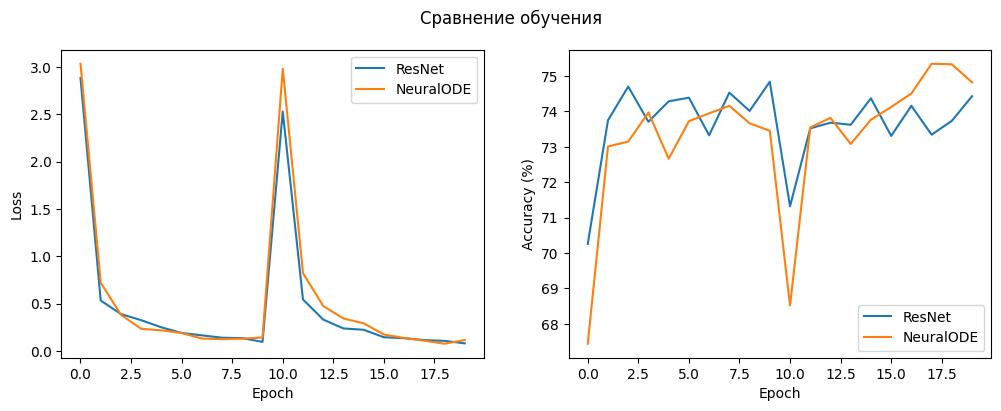

In [287]:

# 5. Визуализация обучения
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot([x['loss'] for x in results['ResNet']], label='ResNet')
plt.plot([x['loss'] for x in results['NeuralODE']], label='NeuralODE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot([x['acc'] for x in results['ResNet']], label='ResNet')
plt.plot([x['acc'] for x in results['NeuralODE']], label='NeuralODE')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.suptitle('Сравнение обучения')
plt.show()


In [302]:

# 6. Тестирование
def test_model(model, test_loader):
    model.eval()
    test_loss = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device).float().unsqueeze(1)
            output = model(data)
            loss = criterion(output, target)
            
            test_loss.append(loss.item())
            predicted = (torch.sigmoid(output) > 0.5).float()*8
            correct += (predicted == target).sum().item()
            total += target.size(0)
            
    return {
        'loss': np.mean(test_loss),
        'acc': 100 * correct / total
    }

resnet_test = test_model(resnet, test_loader)
node_test = test_model(neural_ode, test_loader)

print(f'ResNet Test | Loss: {resnet_test["loss"]:.4f}, Acc: {resnet_test["acc"]:.2f}%')
print(f'NeuralODE Test | Loss: {node_test["loss"]:.4f}, Acc: {node_test["acc"]:.2f}%')


ResNet Test | Loss: 0.3121, Acc: 69.45%
NeuralODE Test | Loss: 4.7369, Acc: 51.13%


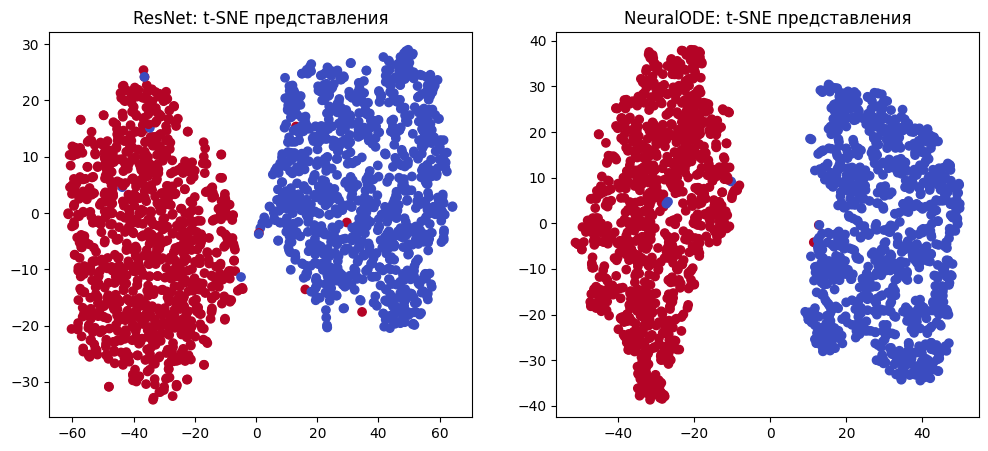

In [289]:

# 7. Визуализация скрытых представлений
def extract_features(model, loader):
    features = []
    labels = []
    model.eval()
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            x = model.encoder(data.view(data.size(0), -1))
            if isinstance(model, NeuralODE):
                x = model.odeblock(x)
            features.append(x.cpu())
            labels.append(target.cpu())
    return torch.cat(features), torch.cat(labels)

resnet_features, resnet_labels = extract_features(resnet, test_loader)
neural_ode_features, neural_ode_labels = extract_features(neural_ode, test_loader)

# t-SNE визуализация
tsne = TSNE(n_components=2, random_state=0)
resnet_tsne = tsne.fit_transform(resnet_features.numpy())
neural_ode_tsne = tsne.fit_transform(neural_ode_features.numpy())

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.scatter(resnet_tsne[:,0], resnet_tsne[:,1], c=resnet_labels.numpy(), cmap='coolwarm')
plt.title('ResNet: t-SNE представления')

plt.subplot(122)
plt.scatter(neural_ode_tsne[:,0], neural_ode_tsne[:,1], c=neural_ode_labels.numpy(), cmap='coolwarm')
plt.title('NeuralODE: t-SNE представления')
plt.show()


In [275]:

# 8. Сравнение ресурсов
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print('\nРесурсы:')
print(f'ResNet | Среднее время/эпох: {np.mean([x["time"] for x in results["ResNet"]]):.2f}s')
print(f'NeuralODE | Среднее время/эпох: {np.mean([x["time"] for x in results["NeuralODE"]]):.2f}s')

print(f'ResNet | Параметров: {count_parameters(resnet)} ')
print(f'NeuralODE | Параметров: {count_parameters(neural_ode )} ')
# print(f'\nResNet | Пиковая память: {max([x["memory"] for x in results["ResNet"]])} MB')
# print(f'NeuralODE | Пиковая память: {max([x["memory"] for x in results["NeuralODE"]])} MB')


Ресурсы:
ResNet | Среднее время/эпох: 1.19s
NeuralODE | Среднее время/эпох: 1.37s
ResNet | Параметров: 1896625 
NeuralODE | Параметров: 58625 


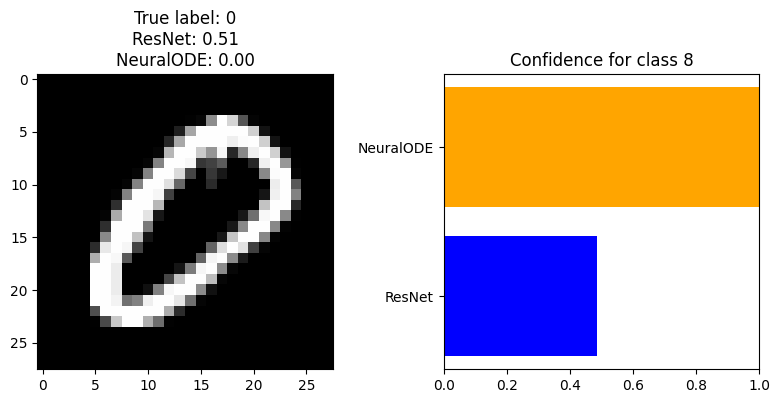

True label: 0
ResNet prediction: 8 (0.5142)
NeuralODE prediction: 0 (0.0000)


In [265]:
# Предсказания
i = 2
image = images[i]
true_label = labels[i]
input_tensor = image
with torch.no_grad():
    resnet_pred = torch.sigmoid(resnet(input_tensor)).item()
    neural_ode_pred = torch.sigmoid(neural_ode(input_tensor)).item()

# Визуализация
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f'True label: {true_label}\nResNet: {resnet_pred:.2f}\nNeuralODE: {neural_ode_pred:.2f}')

# Добавляем график уверенности
plt.subplot(122)
plt.barh(['ResNet', 'NeuralODE'], 
         [resnet_pred if true_label == 8 else 1-resnet_pred, 
          neural_ode_pred if true_label == 8 else 1-neural_ode_pred], 
         color=['blue', 'orange'])
plt.xlim(0, 1)
plt.title('Confidence for class 8')
plt.tight_layout()
plt.show()

print(f"True label: {true_label}")
print(f"ResNet prediction: {'8' if resnet_pred > 0.5 else '0'} ({resnet_pred:.4f})")
print(f"NeuralODE prediction: {'8' if neural_ode_pred > 0.5 else '0'} ({neural_ode_pred:.4f})")

In [300]:
neural_ode.odeblock.integration_time = torch.tensor(np.linspace(0,1.5, 8)).float()

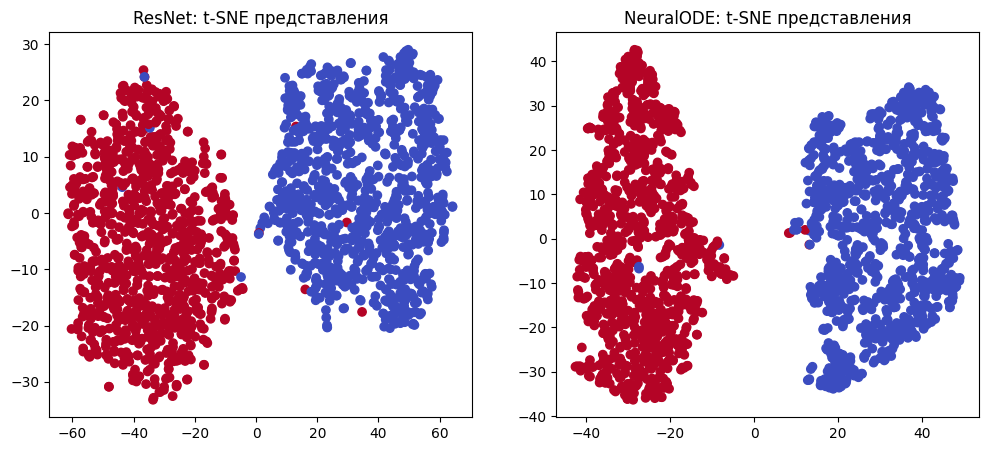

In [301]:

# 7. Визуализация скрытых представлений
def extract_features(model, loader):
    features = []
    labels = []
    model.eval()
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            x = model.encoder(data.view(data.size(0), -1))
            if isinstance(model, NeuralODE):
                x = model.odeblock(x)
            features.append(x.cpu())
            labels.append(target.cpu())
    return torch.cat(features), torch.cat(labels)

resnet_features, resnet_labels = extract_features(resnet, test_loader)
neural_ode_features, neural_ode_labels = extract_features(neural_ode, test_loader)

# t-SNE визуализация
tsne = TSNE(n_components=2, random_state=0)
resnet_tsne = tsne.fit_transform(resnet_features.numpy())
neural_ode_tsne = tsne.fit_transform(neural_ode_features.numpy())

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.scatter(resnet_tsne[:,0], resnet_tsne[:,1], c=resnet_labels.numpy(), cmap='coolwarm')
plt.title('ResNet: t-SNE представления')

plt.subplot(122)
plt.scatter(neural_ode_tsne[:,0], neural_ode_tsne[:,1], c=neural_ode_labels.numpy(), cmap='coolwarm')
plt.title('NeuralODE: t-SNE представления')
plt.show()


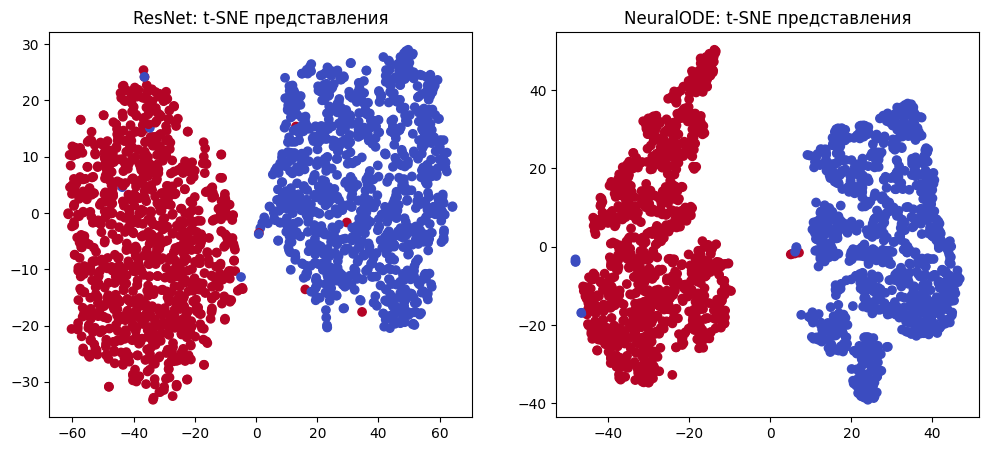

In [293]:

# 7. Визуализация скрытых представлений
def extract_features(model, loader):
    features = []
    labels = []
    model.eval()
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            x = model.encoder(data.view(data.size(0), -1))
            if isinstance(model, NeuralODE):
                x = model.odeblock(x)
            features.append(x.cpu())
            labels.append(target.cpu())
    return torch.cat(features), torch.cat(labels)

resnet_features, resnet_labels = extract_features(resnet, test_loader)
neural_ode_features, neural_ode_labels = extract_features(neural_ode, test_loader)

# t-SNE визуализация
tsne = TSNE(n_components=2, random_state=0)
resnet_tsne = tsne.fit_transform(resnet_features.numpy())
neural_ode_tsne = tsne.fit_transform(neural_ode_features.numpy())

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.scatter(resnet_tsne[:,0], resnet_tsne[:,1], c=resnet_labels.numpy(), cmap='coolwarm')
plt.title('ResNet: t-SNE представления')

plt.subplot(122)
plt.scatter(neural_ode_tsne[:,0], neural_ode_tsne[:,1], c=neural_ode_labels.numpy(), cmap='coolwarm')
plt.title('NeuralODE: t-SNE представления')
plt.show()
